# Baseline Demo for neural signal forecasting

In [13]:
# Build dataloader
import torch
import numpy as np
import os

input_dir = '../data'

In [14]:
# prompt: write a function for torch dataloader

from torch.utils.data import DataLoader, Dataset, TensorDataset


def load_dataset(filename):
    """
    Load test dataset from file.

    Args:
        filename: Name of the test data file

    Returns:
        train_data: Samples to train with shape
                  (num_samples, num_timestep, num_channels, num_bands)
        test_data: Samples to test with shape
                  (num_samples, num_timestep, num_channels, num_bands)
        val_data: Samples to validate with shape
                  (num_samples, num_timestep, num_channels, num_bands)
    """
    test_file = os.path.join(input_dir, filename)
    # Open the file and load the data
    # split into train(80%), test(10%), val(10%)
    data = np.load(test_file)['arr_0']
    train_data = data[:int(len(data)*0.8)]
    test_data = data[int(len(data)*0.8):int(len(data)*0.9)]
    val_data = data[int(len(data)*0.9):]

    return train_data, test_data, val_data


def normalize(data, average=[], std=[]):
    # normalizing input to the range of [~mean - 4*std, ~mean + 4*std]
    # becasue in this dataset, the timestep is in first dimension.
    # adapt the normalization to fit this situation, compute mean and std in axis 0
    if data.ndim == 4:
        n, t, c, f = data.shape
        data = data.reshape((n*t, -1))  # neuron input
    if len(average) == 0:
        average = np.mean(data, axis=0, keepdims=True)
        std = np.std(data, axis=0, keepdims=True)
    combine_max = average + 4 * std
    combine_min = average - 4 * std
    norm_data = 2 * (data - combine_min) / (combine_max - combine_min) - 1
    norm_data = norm_data.reshape((n, t, c, f))
    return norm_data, average, std


class NeuroForcastDataset(Dataset):
  def __init__(self, neural_data, use_graph=False, average=[], std=[]):
    """
    neural_data: N*T*C*F (sampe size * total time steps * channel *feature dimension)
    f_window: T' the length of prediction window
    batch_size: batch size
    """
    self.data = neural_data
    self.use_graph = use_graph
    if len(average) == 0:
      self.data, self.average, self.std = normalize(self.data)
    else:
      self.data, self.average, self.std = normalize(self.data, average, std)

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, index):
    data = self.data[index]
    if not self.use_graph:
      data = data[:, :, 0]

    data = torch.tensor(data, dtype=torch.float32)
    return data


class NFBaseModel(torch.nn.Module):
  def __init__(self, input_size=96, hidden_size=256):
    super(NFBaseModel, self).__init__()
    self.encoder = torch.nn.GRU(
        input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)
    self.output_layer = torch.nn.Linear(hidden_size, input_size)

  def forward(self, x):
    output, hidden = self.encoder(x)
    output = self.output_layer(output)
    return output

  def predict(self, x):
    output, hidden = self.encoder(x)
    output = self.output_layer(output)
    return output


class Trainer():
  def __init__(self, model, train_data_loader, test_data_loader,
               val_data_loader, loss_fn, optimizer, device, scheduler,
               forecasting_mode, init_steps=10, save_path='', ckpt_path=None):
    """
    Args:
      model: model to train
      train_data_loader: train data loader
      test_data_loader: test data loader
      val_data_loader: validation data loader
      loss_fn: loss function
      optimizer: optimizer
      device: device
      forecasting_mode: either 'one_step' or 'multi_step'
      init_steps: number of initial steps for multi-step forecasting

    """
    self.model = model
    self.train_data_loader = train_data_loader
    self.test_data_loader = test_data_loader
    self.val_data_loader = val_data_loader

    self.loss_fn = loss_fn
    self.optimizer = optimizer
    self.device = device
    self.forecasting_mode = forecasting_mode
    self.init_steps = init_steps

    self.save_path = save_path
    self.ckpt_path = ckpt_path
    if ckpt_path is not None:
      self.load_model(ckpt_path)
    self.model.to(device)
    self.scheduler = scheduler

    self.train_loss = []
    self.test_loss = []
    self.val_loss = []

  def prepare_data(self, data):
    if self.forecasting_mode == 'one_step':
      input_data = data[:, :-1, :]
      target_data = data[:, 1:, :]
    elif self.forecasting_mode == 'multi_step':
      future_step = data.shape[1] - self.init_steps
      # masking out future dataset

      input_data = torch.cat([data[:, :self.init_steps], torch.repeat_interleave(data[:, self.init_steps-1:self.init_steps],
                                                                                 future_step, dim=1)], dim=1)
      target_data = data[:, self.init_steps:]


      # print(f"input_data shape: {input_data.shape}")
      # print(f"target_data shape: {target_data.shape}")
    else:
      raise ValueError(
          'forecasting_mode must be either one_step or multi_step')
    return input_data, target_data

  def loss_function(self, prediction, target):
    if self.forecasting_mode == 'one_step':
      loss = self.loss_fn(prediction, target)
    else:
      loss = self.loss_fn(prediction[:, self.init_steps:], target)
    return loss

  def train(self, num_epochs):
    for epoch in range(num_epochs):
      self.model.train()
      train_loss = 0.0
      for batch in self.train_data_loader:
        batch = batch.to(self.device)
        input_data, target_data = self.prepare_data(batch)
        self.optimizer.zero_grad()
        output = self.model(input_data)
        loss = self.loss_function(output, target_data)
        loss.backward()
        self.optimizer.step()
        train_loss += loss.item()
      if epoch % 10 == 0:
        self.model.eval()
        val_loss = self.validation()
        self.model.train()
        print(f'Epoch {epoch}, Train Loss: {train_loss / len(self.train_data_loader)}, Val Loss:{val_loss / len(self.val_data_loader)}')

  def validation(self):
    self.model.eval()
    val_loss = 0.0
    for batch in self.val_data_loader:
      batch = batch.to(self.device)
      input_data, target_data = self.prepare_data(batch)
      output = self.model(input_data)
      loss = self.loss_fn(output[:, self.init_steps:], target_data)
      val_loss += loss.item()
    return val_loss

  def save_model(self):
    torch.save(self.model.state_dict(), self.save_path)

  def load_model(self, path):
    self.model.load_state_dict(torch.load(self.ckpt_path))

  def prediction(self):
    self.model.eval()
    outputs_pred = []
    outputs_gt = []
    for batch in self.val_data_loader:
      batch = batch.to(self.device)
      input_data, target_data = self.prepare_data(batch)
      output = self.model(input_data)
      outputs_pred.append(output.detach().cpu().numpy())
      outputs_gt.append(target_data.detach().cpu().numpy())
    return outputs_pred, outputs_gt

train_data shape: (788, 20, 239, 9)
test_data shape: (98, 20, 239, 9)
val_data shape: (99, 20, 239, 9)


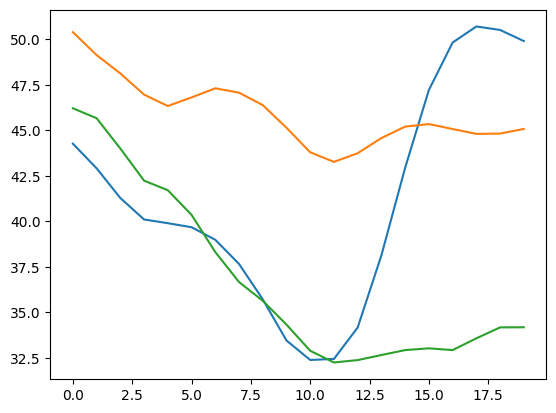

In [15]:
# parameters:
# dataset_name = 'beignet'
dataset_name = 'affi'
if dataset_name == 'beignet':
  num_channels = 89
else:
  num_channels = 239

batch_size = 32
num_epochs = 100
learning_rate = 1e-4
hidden_size = 1024
input_size = num_channels

# define dataloader
train_data, test_data, val_data = load_dataset(
    f'train_data_{dataset_name}.npz')  # B * T * C * F

# print the shape of the train, test, val data
print(f'train_data shape: {train_data.shape}')
print(f'test_data shape: {test_data.shape}')
print(f'val_data shape: {val_data.shape}')

# plot test_data curve for a few channels
import matplotlib.pyplot as plt
plt.plot(test_data[0, :, 0, 1])
plt.plot(test_data[0, :, 1, 1])
plt.plot(test_data[0, :, 2, 1])
plt.show()

In [16]:

# define dataloader

train_data = NeuroForcastDataset(train_data, use_graph=False)

# Save train_data average and std one file
np.savez(f'train_data_average_std_{dataset_name}.npz', average=train_data.average, std=train_data.std)

test_data = NeuroForcastDataset(test_data, use_graph=False, average=train_data.average, std=train_data.std)
val_data = NeuroForcastDataset(val_data, use_graph=False, average=train_data.average, std=train_data.std)
train_data_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_data_loader = DataLoader(val_data, batch_size=32, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NFBaseModel(hidden_size=hidden_size, input_size=input_size)
model = model.to(device)

loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lambda1 = lambda ith_epoch: 0.95 ** (ith_epoch // 50)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)


trainer = Trainer(model, train_data_loader, test_data_loader,
               val_data_loader, loss_fn, optimizer, device=device, scheduler=scheduler,
               forecasting_mode='multi_step', init_steps = 10, save_path ='./model.pth', ckpt_path=None)

trainer.train(100)

#save the model
torch.save(model.state_dict(), f'model_{dataset_name}.pth')

Epoch 0, Train Loss: 0.03505810186266899, Val Loss:0.019955862313508987
Epoch 10, Train Loss: 0.01409427259117365, Val Loss:0.015094112604856491
Epoch 20, Train Loss: 0.01170967135578394, Val Loss:0.016440380830317736
Epoch 30, Train Loss: 0.00870377829298377, Val Loss:0.018420197069644928
Epoch 40, Train Loss: 0.007447924371808768, Val Loss:0.018565300852060318
Epoch 50, Train Loss: 0.005643532611429691, Val Loss:0.01712651806883514
Epoch 60, Train Loss: 0.004561173822730779, Val Loss:0.01702139526605606
Epoch 70, Train Loss: 0.004056928781792522, Val Loss:0.017995307687669992
Epoch 80, Train Loss: 0.0038024593610316514, Val Loss:0.018404243979603052
Epoch 90, Train Loss: 0.002936053527519107, Val Loss:0.017628714442253113


In [17]:
# Run one test event and compare the output with the target

# load the model
model_test = NFBaseModel(hidden_size=hidden_size, input_size=input_size)
model_test = model_test.to(device)
model_test.load_state_dict(torch.load(f'./model_{dataset_name}.pth'))


def prepare_data(data):
    init_steps = 10
    # forecasting_mode == 'multi_step':
    future_step = data.shape[1] - init_steps
    # masking out future dataset

    input_data = torch.cat([data[:, :init_steps], torch.repeat_interleave(
        data[:, init_steps-1:init_steps], future_step, dim=1)], dim=1)
    target_data = data

    return input_data, target_data


# define r2_score and mse_score
def r2_score(target_data, output):
    return 1 - (torch.sum((target_data - output) ** 2) / torch.sum(target_data ** 2))


def mse_score(target_data, output):
    return torch.mean((target_data - output) ** 2)


# define r2_score and mse_score using numpy
def r2_score_np(target_data, output):
    return 1 - (np.sum((target_data - output) ** 2) / np.sum(target_data ** 2))


def mse_score_np(target_data, output):
    return np.mean((target_data - output) ** 2)

# Run model inference and collect predictions


def run_model_inference(model, data_loader, device):
    """
    Run model inference on test data and collect predictions.

    Args:
        model: Trained model
        data_loader: Test data loader
        device: Device to run inference on

    Returns:
        predictions: Model predictions as numpy array
        targets: Ground truth targets as numpy array
    """
    model.eval()
    predictions = []
    targets = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(data_loader):
            batch = batch.to(device)

            # Prepare input and target data
            input_data, target_data = prepare_data(batch)
            output = model(input_data)

            # Store predictions and targets
            predictions.append(output.cpu().numpy())
            targets.append(target_data.cpu().numpy())

    # Concatenate all batches
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)

    return predictions, targets


# Run inference
predictions, targets = run_model_inference(
    model_test, test_data_loader, device)

# Calculate evaluation metrics
r2 = r2_score(torch.tensor(targets), torch.tensor(predictions))
mse = mse_score(torch.tensor(targets), torch.tensor(predictions))

# Calculate evaluation metrics using numpy
r2_np = r2_score_np(np.array(targets), np.array(predictions))
mse_np = mse_score_np(np.array(targets), np.array(predictions))

print(f'Test R2 score: {r2:.4f}')
print(f'Test MSE score: {mse:.4f}')
print(f'Test R2 score(NP): {r2_np:.4f}')
print(f'Test MSE score(NP): {mse_np:.4f}')

Test R2 score: 0.6605
Test MSE score: 0.0195
Test R2 score(NP): 0.6605
Test MSE score(NP): 0.0195


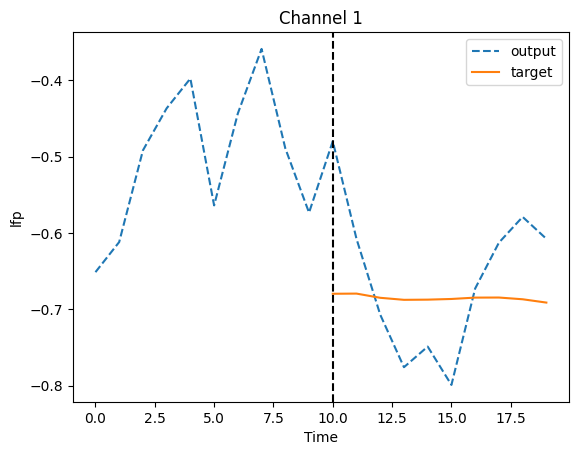

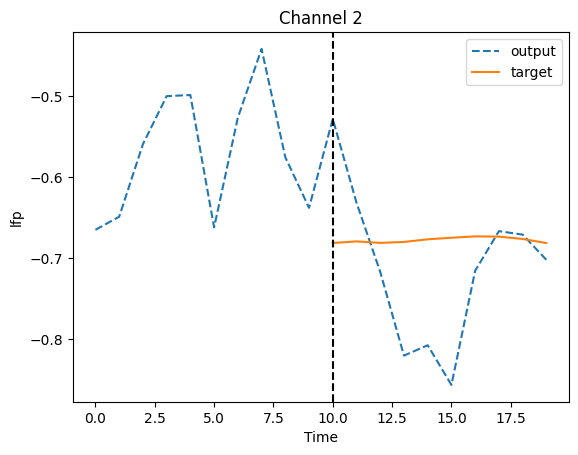

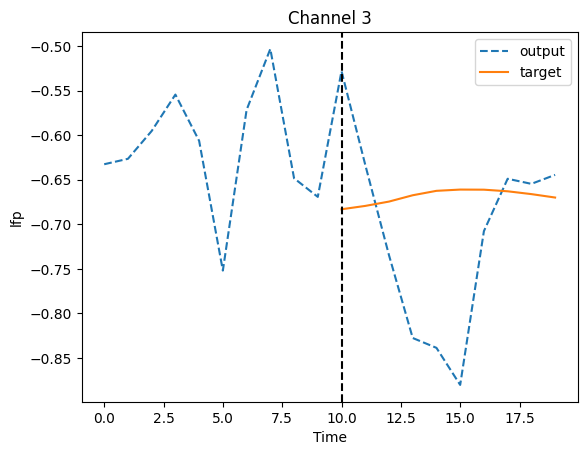

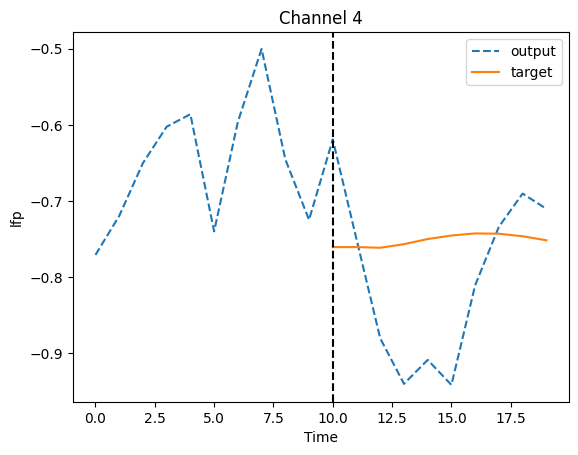

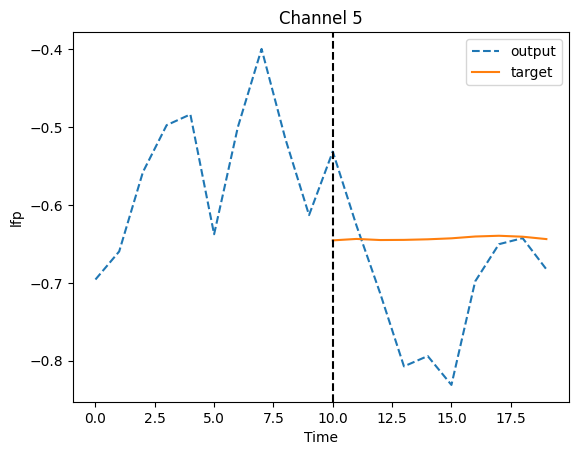

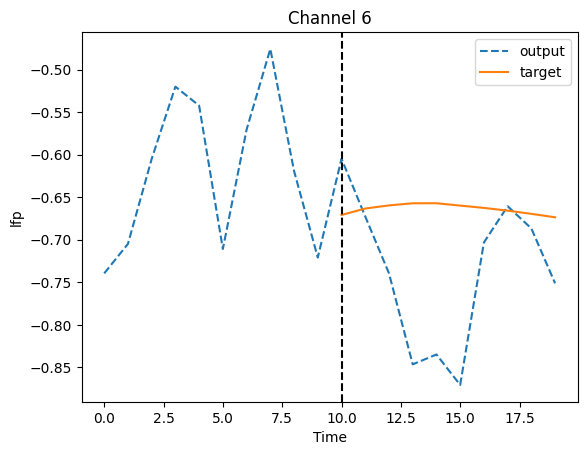

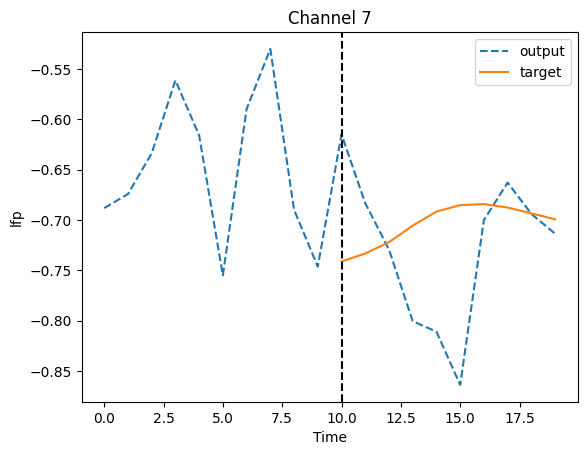

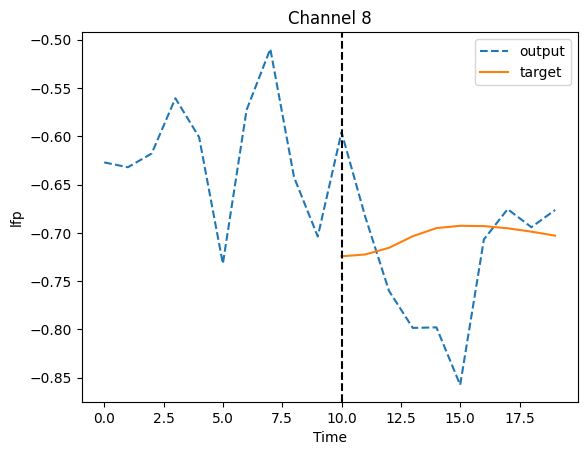

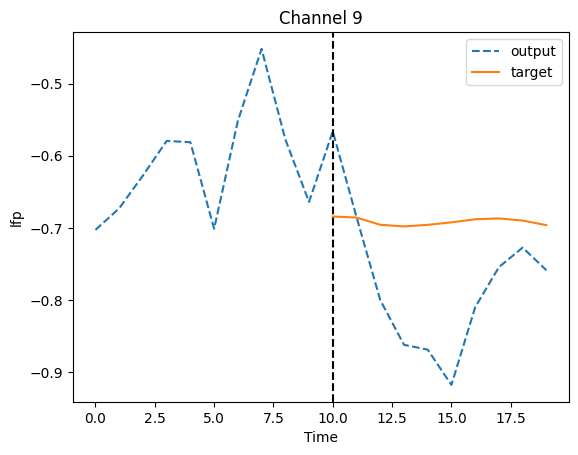

In [18]:
# Compare the output and target data for 1st channel


channel_idx = 1

def plot_channel(channel_idx):
  # plot the output and target data (dotted line)
  # output_data_list start from x = 10 time steps
  plt.plot(targets[0, :, channel_idx], linestyle='--', label='target')
  x_output = np.arange(10, predictions.shape[1])
  plt.plot(x_output, predictions[0, 10:, channel_idx], linestyle='-', label='output')

  # Draw a vertical line at the 10th time step
  plt.axvline(x=10, color='black', linestyle='--')
  plt.legend(['output', 'target'])
  plt.title(f'Channel {channel_idx}')
  plt.xlabel('Time')
  plt.ylabel('lfp')
  plt.show()

plot_channel(1)
plot_channel(2)
plot_channel(3)
plot_channel(4)
plot_channel(5)
plot_channel(6)
plot_channel(7)
plot_channel(8)
plot_channel(9)